In [1]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

import utils
from social_learning import Network

/Users/shumovsk/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# a general framework for SBM generation and for SL simulation

In [3]:
colors = sns.color_palette("tab10")
colors_dark = sns.color_palette("dark")
font = {'size': 10}
matplotlib.rc('font', **font)

np.random.seed(21)

In [4]:
states = 2 # number of hypotheses
clusters_agents = [20, 15] # list of cluster sizes
agents = sum(clusters_agents) # total number of agents
clusters_states = [0, 1] # true state of each cluster
clusters = len(clusters_agents) # total number of clusters

probs = 0.1 * np.ones((clusters, clusters)) # probability matrix of size agents x agents
probs[0,0] = 0.8
probs[1,1] = 0.9
g = nx.stochastic_block_model(clusters_agents, probs, seed=0) # generate the graph (adjacency matrix)

state_true = [] # array of states of each agent
for s, c in zip(clusters_states, clusters_agents):
    state_true = state_true + c*[s]
state_true = np.array(state_true)

N_exp = 1 # experiment number (for monte carlo)
times = 10000 # number of iterations
params = 2 # number of parameters of multinomial random variables
times_skip = 0 # number of iterations to skip after the initialization
step_size = 0.1 # delta from (0, 1); None corresponds to traditional social learning (no delta)

In [5]:
adj_matrix = nx.adjacency_matrix(g).todense()
adj_matrix = np.array(adj_matrix)
combination_matrix, centrality, connected = utils.generate_combination_weights(adj_matrix, 0)

initial_belief = np.ones((states, agents))
initial_belief = initial_belief / initial_belief.sum(0)[None, :]

likelihood = np.array([
    [[1-0.2, 0.2], [0.2, 1-0.2]]
])
likelihood = np.repeat(likelihood, agents, 0)


generator = utils.Generator(likelihood, state_true, 0)

kl_divergence = utils.kl_divergence(likelihood, 0, 1, state_true=state_true, option=0)
slope = (kl_divergence * centrality).sum()

In [6]:
belief_history = []
for _ in tqdm(range(N_exp)):
    network = Network(agents, states, state_true, adj_matrix, combination_matrix, likelihood, generator, initial_belief,
                      step_size=step_size)

    for _ in range(times+times_skip):
        network.step()

    belief_history.append(network.belief_history[times_skip:])

belief_history = np.array(belief_history)

log_befief_history_mean = np.log(belief_history[:,:,0,:] / belief_history[:,:,1,:]).mean(0)

belief_history_mean = np.array(belief_history).mean(0)

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


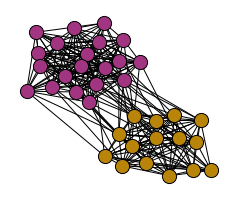

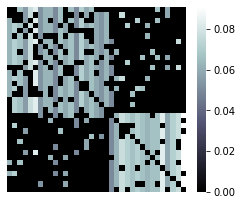

In [7]:
########################################################################

np.random.seed(1)

pos = nx.spring_layout(nx.from_numpy_array(adj_matrix))
G = nx.from_numpy_array(combination_matrix)
edges = G.edges()
weights = [G[u][v]['weight']*10 for u, v in edges]

plt.figure(figsize=(4, 3.4))
nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors_dark[6], node_size=200,
                               nodelist=[i for i in range(clusters_agents[0])])
nodes.set_edgecolor('black')
nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors_dark[-2], node_size=200,
                               nodelist=[i for i in range(clusters_agents[0], clusters_agents[0] + clusters_agents[1])])
nodes.set_edgecolor('black')
nx.draw_networkx_edges(G, pos=pos, edge_color='black')#, width=weights)
plt.box(False)
plt.show()

plt.figure(figsize=(4, 3.4))
sns.heatmap(combination_matrix, yticklabels=False, xticklabels=False, cbar=True,
            cmap=sns.color_palette("bone", as_cmap=True))
plt.show()

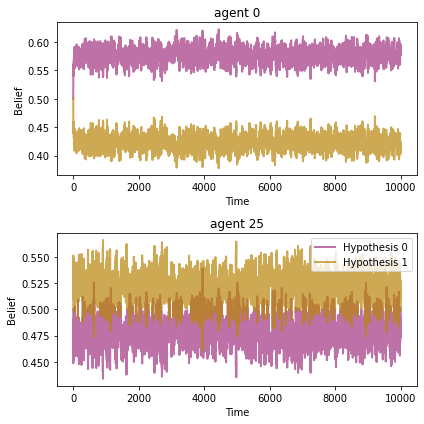

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
for ax, agent in zip(axs, [0, 25]):
    ax.plot(list(range(times + 1)), belief_history[-1,:,0,agent],
            label='Hypothesis 0', color=colors_dark[6], linewidth=2, alpha=0.7)
    ax.plot(list(range(times + 1)), belief_history[-1,:,1,agent],
            label='Hypothesis 1', color=colors_dark[-2], linewidth=2, alpha=0.7)
    ax.title.set_text('agent ' + str(agent))
    ax.set_xlabel('Time')
    ax.set_ylabel('Belief')
ax.legend()
plt.tight_layout()
plt.show()